## Generate relevant plots from the fix reports after running the tests

In [ ]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
def parse_report(path: Path) -> dict:
    metrics = {}
    num_pat = re.compile(r"[-+]?\d*\.?\d+")
    with path.open(encoding="utf-8") as fh:
        for line in fh:
            if ":" not in line:
                continue
            label, _ = line.split(":", 1)
            label = label.strip()
            m = num_pat.search(line)
            if m:
                metrics[label] = float(m.group())

    required = [
        "Total Instances", 
        "Total Correct",
        "Total Runtime Failed", 
        "Total Compilation Failed",
        "Total Test Failed", 
        "Total Infinite Loop",
        "Accuracy", 
        "Runtime Rate", 
        "Compilation Rate",
        "Test Failed Rate", 
        "Infinite Loop Rate"
    ]

    missing = [k for k in required if k not in metrics]
    if missing:
        raise ValueError(f"{path.name}: missing fields {missing}")

    return metrics

## Mapping generated fix report files

In [ ]:
files = [
    ("fix_reports/openai_gpt_4o_avatar_compileReport_from_Python_to_Java.txt", "Avatar - Python → Java"),
    ("fix_reports/openai_gpt_4o_codenet_compileReport_from_Python_to_Java.txt", "Codenet - Python → Java"),
    ("fix_reports/openai_gpt_4o_avatar_compileReport_from_Java_to_Python.txt", "Avatar - Java → Python"),
    ("fix_reports/openai_gpt_4o_codenet_compileReport_from_Java_to_Python.txt", "Codenet - Java → Python"),
]

In [ ]:
records, experiments = {}, []
for fname, label in files:
    records[label] = parse_report(Path(fname))
    experiments.append(label)

total_instances = [records[l]["Total Instances"]          for l in experiments]
total_correct   = [records[l]["Total Correct"]            for l in experiments]
runtime_failed  = [records[l]["Total Runtime Failed"]     for l in experiments]
comp_failed     = [records[l]["Total Compilation Failed"] for l in experiments]
test_failed     = [records[l]["Total Test Failed"]        for l in experiments]
infinite_loop   = [records[l]["Total Infinite Loop"]      for l in experiments]

accuracy_rate   = [records[l]["Accuracy"]             for l in experiments]
runtime_rate    = [records[l]["Runtime Rate"]         for l in experiments]
comp_rate       = [records[l]["Compilation Rate"]     for l in experiments]
test_rate       = [records[l]["Test Failed Rate"]     for l in experiments]
loop_rate       = [records[l]["Infinite Loop Rate"]   for l in experiments]

fail_counts     = [i - c for i, c in zip(total_instances, total_correct)]

## Loading experiment data into dataframe

In [ ]:
df = pd.DataFrame({
    "Total Inst": total_instances,
    "Correct": total_correct,
    "Runtime Fail": runtime_failed,
    "Compile Fail": comp_failed,
    "Test Fail": test_failed,
    "Inf Loop": infinite_loop,
    "Accuracy (%)": np.round(accuracy_rate, 2),
    "Runtime Rate (%)": np.round(runtime_rate, 2),
    "Compile Rate (%)": np.round(comp_rate, 2),
    "Test Rate (%)": np.round(test_rate, 2),
    "Loop Rate (%)": np.round(loop_rate, 2)
    }, index=experiments
)

In [ ]:
if not os.path.exists('figures'):
    os.makedirs('figures')

## Accuracy bar chart

In [ ]:
fig1, ax1 = plt.subplots(figsize=(9, 5))
x = np.arange(len(experiments))
bars = ax1.bar(x, accuracy_rate, color='steelblue', edgecolor='black', width=0.55)

ax1.set_title("Accuracy by Dataset", pad=15, fontsize=13)
ax1.set_ylabel("Accuracy (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(experiments, rotation=0, ha='center')

ax1.set_ylim(0, max(accuracy_rate) + 10)

for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 1,
             f"{bar.get_height():.1f}%",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# fig1.savefig("figures/accuracy_comparison.pdf") # save as pdf
# fig1.savefig("figures/accuracy_comparison.jpg", dpi=300) # save as jpg

## Stacked failure type bar chart

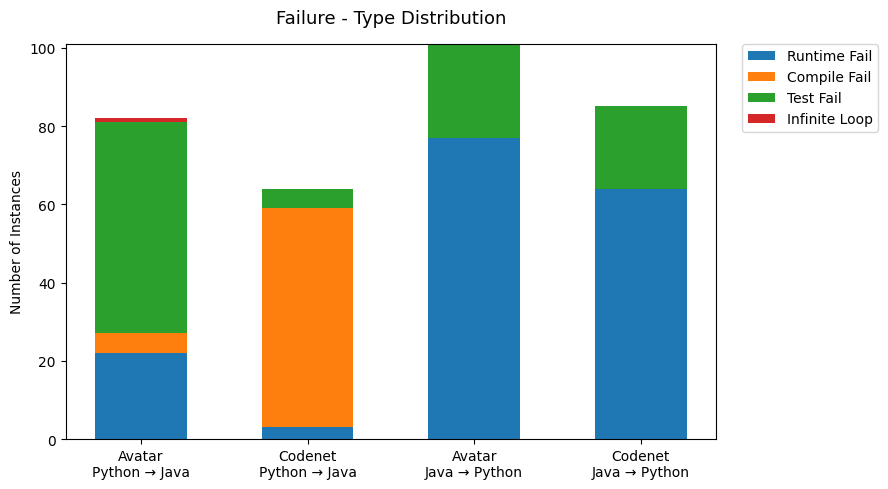

In [19]:
wrap = ["Avatar\nPython → Java",
        "Codenet\nPython → Java",
        "Avatar\nJava → Python",
        "Codenet\nJava → Python"]

fig2, ax2 = plt.subplots(figsize=(9, 5))
p1 = ax2.bar(x, runtime_failed, label="Runtime Fail", width=0.55)
p2 = ax2.bar(x, comp_failed,   bottom=runtime_failed,
             label="Compile Fail", width=0.55)
p3 = ax2.bar(x, test_failed,
             bottom=np.array(runtime_failed) + comp_failed,
             label="Test Fail", width=0.55)
p4 = ax2.bar(x, infinite_loop,
             bottom=np.array(runtime_failed) + comp_failed + test_failed,
             label="Infinite Loop", width=0.55)

ax2.set_title("Failure - Type Distribution", pad=15, fontsize=13)
ax2.set_ylabel("Number of Instances")
ax2.set_xticks(x)
ax2.set_xticklabels(wrap, rotation=0, ha='center', fontsize=10)
ax2.legend(loc="upper left", bbox_to_anchor=(1.04, 1.0), borderaxespad=0.)

plt.subplots_adjust(bottom=0.22)
plt.tight_layout()

fig2.savefig("figures/failure_types_stacked.pdf") # save as pdf
fig2.savefig("figures/failure_types_stacked.jpg", dpi=300) # save as pdf